In [ ]:
#@markdown --------------- 
#@markdown ## **⚠️❗ Ejecute esta celda para descargar Shoes dataset❗⚠️** 
#@markdown ### Esta celda creará la carpeta ```/content/music_images_data```

!pip install -qq gdown
!gdown -qq "https://drive.google.com/u/1/uc?id=125dj7vECjVsUUfPgeDuJLRoaO3kv_DZf&export=download" -O /music_images_data.zip
!mkdir /content/music_images_data/
!unzip -qq /music_images_data.zip -d /content/music_images_data
!rm -r /music_images_data.zip
print ("Done!")
#@markdown ---------------

mkdir: cannot create directory ‘/content/music_images_data/’: File exists
Done!


In [ ]:
import torch 
from torch import nn
from torchsummary import summary
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score, confusion_matrix,f1_score

from PIL import Image
import numpy as np
import time 
from tqdm import tqdm
import matplotlib.pyplot as plt

In [ ]:
image_transforms = transforms.Compose([transforms.Resize((120,120), Image.BICUBIC), 
                                       transforms.ToTensor()])

In [ ]:
#---- Importar librerias. Incluya acá todas las librerías que requiera
train_dataset = datasets.ImageFolder(root= "/content/music_images_data/train" , transform = image_transforms )
test_dataset = datasets.ImageFolder(root= "/content/music_images_data/test" , transform = image_transforms )

train_loader = DataLoader(train_dataset, batch_size=80, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=20)

<built-in method size of Tensor object at 0x7fb26f1312b0> 0


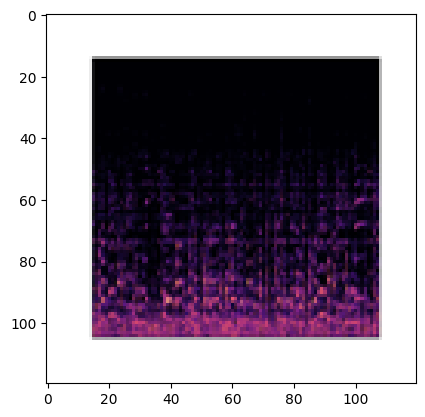

In [ ]:
print ( train_dataset[0][0].size,train_dataset[0][1] )
plt.imshow( train_dataset[0][0].permute(1, 2, 0).numpy() )

In [ ]:
#---- Introduzca su codigo aqui. Puede utilizar cuantas celdas de código considere necesarias

# grab a batch from both training and validation dataloader
trainBatch = next(iter(train_loader))
valBatch = next(iter(test_loader))

In [ ]:
print (trainBatch[1].shape, valBatch[0].shape)
print(len(np.unique(trainBatch[1])))

torch.Size([80]) torch.Size([20, 3, 120, 120])
10


In [ ]:
# maxpool2d de 2 reduce la imagen en 2. usar padding 1 si la imagen tiene fondo, si es fondo blanco todas poner 0 de padding
#tangente hiperbolica para imagenes caoticas
model = nn.Sequential(
    nn.Conv2d(3, 32, kernel_size=3, padding=1),
    nn.MaxPool2d(kernel_size=2),
    nn.Hardsigmoid(),
    nn.Conv2d(32, 64, kernel_size=3, padding=1),
    nn.MaxPool2d(kernel_size=2),
    nn.Hardsigmoid(),
    nn.Conv2d(64, 128, kernel_size=3, padding=1),
    nn.MaxPool2d(kernel_size=2),
    nn.Hardsigmoid(),
    nn.Conv2d(128, 256, kernel_size=3, padding=1),
    nn.MaxPool2d(kernel_size=2),
    nn.Hardsigmoid(),
    nn.Flatten(),
    nn.Linear(256 * 7 * 7, 512),
    nn.Hardsigmoid(),
    nn.Linear(512, 256),
    nn.Hardsigmoid(),
    nn.Linear(256, 128),
    nn.Hardsigmoid(),
    nn.Linear(128, 10),
    nn.Softmax(dim=1)
)

model.cuda()
summary(model, input_size=( 3,120,120 ))
# print (model)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 120, 120]             896
         MaxPool2d-2           [-1, 32, 60, 60]               0
       Hardsigmoid-3           [-1, 32, 60, 60]               0
            Conv2d-4           [-1, 64, 60, 60]          18,496
         MaxPool2d-5           [-1, 64, 30, 30]               0
       Hardsigmoid-6           [-1, 64, 30, 30]               0
            Conv2d-7          [-1, 128, 30, 30]          73,856
         MaxPool2d-8          [-1, 128, 15, 15]               0
       Hardsigmoid-9          [-1, 128, 15, 15]               0
           Conv2d-10          [-1, 256, 15, 15]         295,168
        MaxPool2d-11            [-1, 256, 7, 7]               0
      Hardsigmoid-12            [-1, 256, 7, 7]               0
          Flatten-13                [-1, 12544]               0
           Linear-14                  [

In [ ]:
loss = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 1e-4)

model.cuda()
loss.cuda()

CrossEntropyLoss()

In [ ]:
epochs = 100
batch_size = 200
losses = []

start_time = time.time()
progress = tqdm(range( epochs ), ncols=110)

for epoch in progress:
  #
  batch_losses = 0
  
  # for batch_i in range(0, len(X_train) , batch_size):
  for batch_i, (batch_X, batch_y) in enumerate(train_loader):
    #
    batch_X = batch_X.cuda()
    batch_y = batch_y.cuda()

    # Zero the gradients
    optimizer.zero_grad()

    # Perform forward pass
    predictions = model(batch_X)

    # Compute loss
    batch_loss = loss( predictions , batch_y )

    # Perform backward pass
    batch_loss.backward()

    # Optimize parameters
    optimizer.step()

    ## Save stats
    batch_losses += batch_loss.item()

    elapsed_time = time.time() - start_time
    
  progress.set_description("Epoch [%d/%d] [Loss: %f] time: %3f" % (epoch, epochs,
                                                                   batch_loss.item(),
                                                                   elapsed_time))
  
  losses.append(batch_losses/(len(train_loader)/batch_size))


Epoch [99/100] [Loss: 2.302521] time: 390.543595: 100%|█████████████████████| 100/100 [06:30<00:00,  3.91s/it]


Text(0.5, 0, 'Epoch')

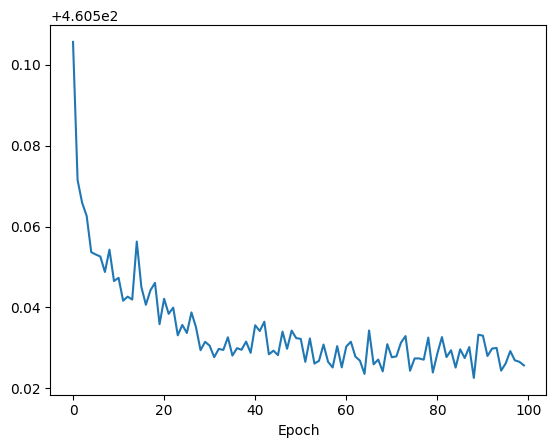

In [ ]:
import seaborn as sns

plt.plot(np.array( losses ))
plt.xlabel("Epoch")

acc: 0.1
f1 score:0.10000000000000002


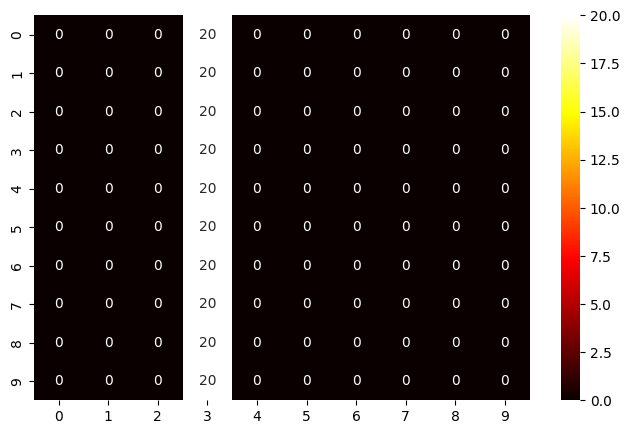

In [ ]:
# Get predictions and calculate test loss
test_loss = 0.0
all_labels = []
all_predictions = []
with torch.no_grad():
    for images, labels in test_loader:
        images = images.cuda()
        labels = labels.cuda()
        predictions = model(images)
        loss_metric = loss(predictions, labels)
        test_loss += loss_metric.item()
        _, predicted = torch.max(predictions.data, 1)
        all_labels += labels.cpu().numpy().tolist()
        all_predictions += predicted.cpu().numpy().tolist()
acc = accuracy_score  ( all_labels,all_predictions )
cm_ = confusion_matrix( all_labels , all_predictions )
f1 = f1_score( all_labels , all_predictions , average = "micro")

_, ax = plt.subplots(figsize=(8,5))
sns.heatmap(cm_, cmap="hot", annot=True, ax=ax)
print("acc: {0}\nf1 score:{1}".format(acc,f1))